# SAFETY RECOMMENDER

## Data Ingestion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn
import IPython
import sys
import os
import json
import time
import pickle
import requests
import pandas.io.sql as pd_sql
import sqlite3 as sql
import csv
import graphviz


from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer 
from sklearn.base import BaseEstimator, TransformerMixin 

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 

from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split as tts 

%matplotlib inline

C:\Users\Judith\Anaconda3\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.0.3) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
#Pandas will not display all columns in our data when using the head() function without this
pd.set_option('max_columns',50) 

In [3]:
#this takes about 10 seconds
URL = "https://datagate.dc.gov/search/open/crimes?daterange=2years&details=true&format=csv"

def fetch_data(fname="dc-crimes-search-results.csv"):
    """
    Helper method to retrieve the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

DATA = fetch_data()


In [4]:
def load_df(path=DATA):
    return pd.read_csv(path)

In [5]:
df = load_df()

## Data Exploration 1

In [6]:
df.columns

Index(['NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT', 'offensegroup', 'LONGITUDE',
       'END_DATE', 'offense-text', 'SHIFT', 'YBLOCK', 'DISTRICT', 'WARD',
       'YEAR', 'offensekey', 'BID', 'sector', 'PSA', 'ucr-rank', 'BLOCK_GROUP',
       'VOTING_PRECINCT', 'XBLOCK', 'BLOCK', 'START_DATE', 'CCN', 'OFFENSE',
       'ANC', 'REPORT_DAT', 'METHOD', 'location', 'LATITUDE'],
      dtype='object')

In [7]:
# Use pandas to get the summary statistics on the data.

df.describe()

,CENSUS_TRACT,LONGITUDE,YBLOCK,DISTRICT,WARD,YEAR,PSA,ucr-rank,XBLOCK,CCN,LATITUDE
count,68246.000000,68405.000000,68405.000000,68383.000000,68405.000000,68405.000000,68377.000000,68405.000000,68405.000000,6.840500e+04,68405.000000
mean,6246.898881,-77.007665,137645.435352,3.672272,4.422454,2016.838784,371.779604,6.054835,399335.723267,1.696359e+07,38.906661
std,3118.224225,0.036087,3362.971224,1.953244,2.338953,0.700419,195.142451,1.296839,3129.886007,7.680898e+05,0.030294
min,100.000000,-77.113642,127300.000000,1.000000,1.000000,2016.000000,101.000000,1.000000,390147.000000,2.111617e+06,38.813471
25%,3600.000000,-77.031224,136110.000000,2.000000,2.000000,2016.000000,206.000000,6.000000,397293.000000,1.619087e+07,38.892836
50%,7000.000000,-77.012414,137594.000000,3.000000,5.000000,2017.000000,308.000000,6.000000,398923.000000,1.707798e+07,38.906202
75%,9000.000000,-76.985491,139610.000000,5.000000,6.000000,2017.000000,506.000000,7.000000,401258.000000,1.719733e+07,38.924339
max,11100.000000,-76.910021,147292.000000,7.000000,8.000000,2018.000000,708.000000,9.000000,407806.000000,8.501717e+07,38.993560


## Data Wrangling 1 -- Parse Start Date into Month, Day, Hour

In [8]:
import datetime

In [9]:
#Create a new column with the datetime month
def label_month (row):
    startdate = (row['START_DATE'] ).replace("Z","")
    startdate2 = datetime.datetime.strptime(startdate, "%Y-%m-%dT%H:%M:%S.%f")
    return startdate2.month


In [10]:
df['start_month'] = df.apply (lambda row: label_month (row),axis=1)
#This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [11]:
#Create a new column with the datetime day
def label_day (row):
    startdate = (row['START_DATE'] ).replace("Z","")
    startdate2 = datetime.datetime.strptime(startdate, "%Y-%m-%dT%H:%M:%S.%f")
    return startdate2.day


In [12]:
df['start_day'] = df.apply (lambda row: label_day (row),axis=1)
#This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [13]:
#Create a new column with the datetime hour
def label_hour (row):
    startdate = (row['START_DATE'] ).replace("Z","")
    startdate2 = datetime.datetime.strptime(startdate, "%Y-%m-%dT%H:%M:%S.%f")
    return startdate2.hour


In [14]:
df['start_hour'] = df.apply (lambda row: label_hour (row),axis=1)
# This takes about 10 seconds so wait for asterisk to disappear before proceeding

## Data Wrangling 2 - Add a column with all positive Longitude values for ML purposes

In [15]:
#Create a new column with a positive longitude
def label_longitude2 (row):
    longitude = row['LONGITUDE']
    longitude2 = longitude * -1
    return longitude2

In [16]:
df['longitude2'] = df.apply (lambda row: label_longitude2 (row),axis=1)
# This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [17]:
# See new columns for start month, day, hour, positive longitude
df.columns

Index(['NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT', 'offensegroup', 'LONGITUDE',
       'END_DATE', 'offense-text', 'SHIFT', 'YBLOCK', 'DISTRICT', 'WARD',
       'YEAR', 'offensekey', 'BID', 'sector', 'PSA', 'ucr-rank', 'BLOCK_GROUP',
       'VOTING_PRECINCT', 'XBLOCK', 'BLOCK', 'START_DATE', 'CCN', 'OFFENSE',
       'ANC', 'REPORT_DAT', 'METHOD', 'location', 'LATITUDE', 'start_month',
       'start_day', 'start_hour', 'longitude2'],
      dtype='object')

In [18]:
df.head(10)

,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,offensegroup,LONGITUDE,END_DATE,offense-text,SHIFT,YBLOCK,DISTRICT,WARD,YEAR,offensekey,BID,sector,PSA,ucr-rank,BLOCK_GROUP,VOTING_PRECINCT,XBLOCK,BLOCK,START_DATE,CCN,OFFENSE,ANC,REPORT_DAT,METHOD,location,LATITUDE,start_month,start_day,start_hour,longitude2
0,cluster 32,7708.0,property,-76.955521,2016-10-04T16:37:29.000,motor vehicle theft,evening,135396.0,6.0,7,2016,property|motor vehicle theft,NaN,6D3,603.0,8,007708 2,precinct 132,403859.0,3500 - 3526 block of minnesota avenue se,2016-10-04T16:09:08.000,16168699,motor vehicle theft,7B,2016-10-05T03:00:47.000Z,others,"38.886402972929169,-76.955523453842957",38.886395,10,4,16,76.955521
1,cluster 4,100.0,property,-77.059614,2016-10-04T17:44:13.000,theft/other,evening,137194.0,2.0,2,2016,property|theft/other,georgetown,2D3,206.0,6,000100 4,precinct 5,394829.0,3000 - 3029 block of k street nw,2016-10-04T17:00:48.000,16168738,theft/other,2E,2016-10-05T01:36:11.000Z,others,"38.902593275715809,-77.059616752356732",38.902585,10,4,17,77.059614
2,cluster 23,8904.0,property,-76.981924,2016-10-04T20:10:43.000,theft/other,evening,136987.0,5.0,5,2016,property|theft/other,NaN,5D3,507.0,6,008904 2,precinct 79,401568.0,1500 - 1599 block of maryland avenue ne,2016-10-04T19:21:09.000,16168845,theft/other,5D,2016-10-05T02:21:19.000Z,others,"38.900742359981244,-76.981925885322667",38.900735,10,4,19,76.981924
3,cluster 29,9601.0,violent,-76.937531,2016-10-14T00:12:56.000,robbery,midnight,138092.0,6.0,7,2016,violent|robbery,NaN,6D1,601.0,4,009601 1,precinct 92,405418.0,1500 1535 block of 45th street ne,2016-10-13T22:45:39.000,16174401,robbery,7D,2016-10-14T05:31:03.000Z,gun,"38.910681288493713,-76.937533164068512",38.910673,10,13,22,76.937531
4,cluster 25,10600.0,violent,-76.995538,2016-10-22T16:40:05.000,robbery,evening,137463.0,5.0,6,2016,violent|robbery,NaN,5D3,506.0,4,010600 1,precinct 83,400387.0,700 - 799 block of florida avenue ne,2016-10-22T16:24:12.000,16180021,robbery,6C,2016-10-22T22:55:30.000Z,gun,"38.90503165003841,-76.995540557600265",38.905024,10,22,16,76.995538
5,cluster 2,3200.0,property,-77.021405,2016-10-22T22:56:31.000,theft f/auto,midnight,140137.0,3.0,1,2016,property|theft f/auto,NaN,3D1,302.0,7,003200 4,precinct 38,398144.0,500 - 699 block of irving street nw,2016-10-22T20:21:52.000,16180127,theft f/auto,1A,2016-10-24T04:29:28.000Z,others,"38.929118054612083,-77.021407353091945",38.929110,10,22,20,77.021405
6,cluster 31,7807.0,property,-76.922953,NaN,theft/other,midnight,137294.0,6.0,7,2016,property|theft/other,NaN,6D1,608.0,6,007807 2,precinct 95,406683.0,934 - 1099 block of eastern avenue ne,2016-10-22T21:53:20.000,16180199,theft/other,7C,2016-10-23T04:11:28.000Z,others,"38.903483920886075,-76.922955583391357",38.903476,10,22,21,76.922953
7,cluster 6,10700.0,property,-77.040088,2016-10-23T04:28:53.000,theft f/auto,midnight,137847.0,2.0,2,2016,property|theft f/auto,NaN,2D3,208.0,7,010700 2,precinct 15,396523.0,1700 - 1799 block of massachusetts avenue nw,2016-10-23T01:30:55.000,16180348,theft f/auto,2B,2016-10-23T09:24:07.000Z,others,"38.908484062358717,-77.040090587782586",38.908476,10,23,1,77.040088
8,cluster 17,1804.0,property,-77.031560,2016-10-23T06:00:06.000,theft f/auto,day,144484.0,4.0,4,2016,property|theft f/auto,NaN,4D1,402.0,7,001804 1,precinct 61,397265.0,1300 - 1399 block of tewkesbury place nw,2016-10-22T09:00:04.000,16180372,theft f/auto,4A,2016-10-23T11:46:17.000Z,others,"38.968274741325793,-77.031562108374985",38.968267,10,22,9,77.031560
9,cluster 26,7000.0,property,-76.996185,2016-11-01T10:00:39.000,theft f/auto,day,134740.0,1.0,6,2016,property|theft f/auto,NaN,1D3,106.0,7,007000 1,precinct 90,400331.0,700 - 753 block of 7th street se,2016-11-01T08:30:07.000,16186247,theft f/auto,6B,2016-11-01T15:26:46.000Z,others,"38.880501876434913,-76.996187492452577",38.880494,11,1,8,76.996185


## Data Exploration 2 - UCR Rank

Look at ucrrank (Uniform Crime Report Rank). DC uses this index (1-9) to rank crime severity. This is how the ucrrank relates to crime detail: 

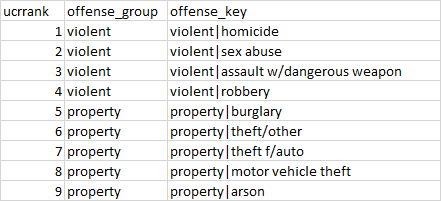

Notice that a ucrrank of 1 is assigned to the most serious type of crime and 9 to the least serious.  

In [19]:
# Use pandas to get the median of the ucrrank column. DataFrame.median(axis=None, skipna=None, level=None, numeric_only=None, **kwargs)[source]
df['ucr-rank'].median()

6.0

In [20]:
# Use pandas to find the number of unique values in the ucrrank column. Series.nunique(dropna=True)[source]¶
df['ucr-rank'].nunique()

9

In [21]:
df.dtypes

NEIGHBORHOOD_CLUSTER     object
CENSUS_TRACT            float64
offensegroup             object
LONGITUDE               float64
END_DATE                 object
offense-text             object
SHIFT                    object
YBLOCK                  float64
DISTRICT                float64
WARD                      int64
YEAR                      int64
offensekey               object
BID                      object
sector                   object
PSA                     float64
ucr-rank                  int64
BLOCK_GROUP              object
VOTING_PRECINCT          object
XBLOCK                  float64
BLOCK                    object
START_DATE               object
CCN                       int64
OFFENSE                  object
ANC                      object
REPORT_DAT               object
METHOD                   object
location                 object
LATITUDE                float64
start_month               int64
start_day                 int64
start_hour                int64
longitud

In [22]:
# Use pandas to count the number of each unique ucrrank value.
df['ucr-rank'].value_counts()

6    28846
7    21756
8     5023
4     4661
3     3865
5     3357
2      628
1      259
9       10
Name: ucr-rank, dtype: int64

## Visualize the Data
Now let's look at two histograms of the ```Fare``` data. In the first, we'll set ```bins=10``` and in the second ```bin=50```. Which one do you find the most helpful? What are you able to tell about the range of fares paid by the passengers from the histograms?

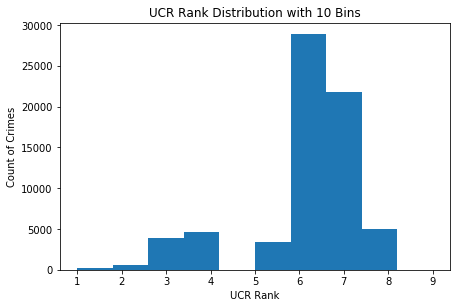

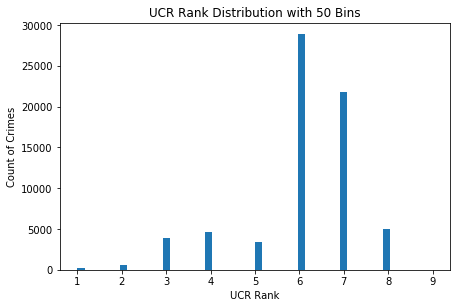

In [23]:
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(211)
ax.hist(df['ucr-rank'], bins=10, range=(df['ucr-rank'].min(),df['ucr-rank'].max()))
plt.title('UCR Rank Distribution with 10 Bins')
plt.xlabel('UCR Rank')
plt.ylabel('Count of Crimes')
plt.show()

fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(212)
ax.hist(df['ucr-rank'], bins=50, range=(df['ucr-rank'].min(),df['ucr-rank'].max()))
plt.title('UCR Rank Distribution with 50 Bins')
plt.xlabel('UCR Rank')
plt.ylabel('Count of Crimes')
plt.show()

## Delete Features

Reduce dataframe to only numerics as required for machine learning. I will convert some categorical features like offense and offense group in future versions.   

In [24]:

df2 = df.drop(['LONGITUDE','NEIGHBORHOOD_CLUSTER','CENSUS_TRACT','offensegroup','END_DATE','offense-text','SHIFT','YBLOCK','DISTRICT','WARD','offensekey','BID','sector','PSA','BLOCK_GROUP','VOTING_PRECINCT','XBLOCK','BLOCK','CCN','OFFENSE','ANC','REPORT_DAT','METHOD','location'], axis=1)

In [25]:
df2.head(10)

,YEAR,ucr-rank,START_DATE,LATITUDE,start_month,start_day,start_hour,longitude2
0,2016,8,2016-10-04T16:09:08.000,38.886395,10,4,16,76.955521
1,2016,6,2016-10-04T17:00:48.000,38.902585,10,4,17,77.059614
2,2016,6,2016-10-04T19:21:09.000,38.900735,10,4,19,76.981924
3,2016,4,2016-10-13T22:45:39.000,38.910673,10,13,22,76.937531
4,2016,4,2016-10-22T16:24:12.000,38.905024,10,22,16,76.995538
5,2016,7,2016-10-22T20:21:52.000,38.929110,10,22,20,77.021405
6,2016,6,2016-10-22T21:53:20.000,38.903476,10,22,21,76.922953
7,2016,7,2016-10-23T01:30:55.000,38.908476,10,23,1,77.040088
8,2016,7,2016-10-22T09:00:04.000,38.968267,10,22,9,77.031560
9,2016,7,2016-11-01T08:30:07.000,38.880494,11,1,8,76.996185


In [26]:
df2.rename(columns={'START_DATE':'datetime'}, inplace=True)

In [27]:
df2.head(10)

,YEAR,ucr-rank,datetime,LATITUDE,start_month,start_day,start_hour,longitude2
0,2016,8,2016-10-04T16:09:08.000,38.886395,10,4,16,76.955521
1,2016,6,2016-10-04T17:00:48.000,38.902585,10,4,17,77.059614
2,2016,6,2016-10-04T19:21:09.000,38.900735,10,4,19,76.981924
3,2016,4,2016-10-13T22:45:39.000,38.910673,10,13,22,76.937531
4,2016,4,2016-10-22T16:24:12.000,38.905024,10,22,16,76.995538
5,2016,7,2016-10-22T20:21:52.000,38.929110,10,22,20,77.021405
6,2016,6,2016-10-22T21:53:20.000,38.903476,10,22,21,76.922953
7,2016,7,2016-10-23T01:30:55.000,38.908476,10,23,1,77.040088
8,2016,7,2016-10-22T09:00:04.000,38.968267,10,22,9,77.031560
9,2016,7,2016-11-01T08:30:07.000,38.880494,11,1,8,76.996185


## Save to csv file

In [28]:
#save to csv
df2.to_csv("c:\\Users\\Judith\\projects\\safetyrecommender\\data\\safetyrecommender.csv", index = False)

# Machine Learning Exploration

## Load the data two ways: further exploration and machine learning

In [29]:
DATA = os.path.join("data", "safetyrecommender.csv")
#DTFMT = '%Y-%m-%d %H:%M:%S.%f"'
#2016-10-04T16:09:08.000
#2/4/2015 17:51
DTFMT = '%Y-%m-%dT%H:%M:%S.000'

def load_raw(path=DATA):
    with open(path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            # Pop target off of features dictionary 
            target = row.pop('ucr-rank')
            
            # Convert fields to floats
            for field in ('YEAR', 'LATITUDE', 'start_month', 'start_day', 'start_hour', 'longitude2'):
                row[field] = float(row[field])
            
            # Parse datetime
            row['datetime'] = datetime.strptime(row['datetime'], DTFMT)
            
            yield row, target
            
            
def load_df(path=DATA):
    return pd.read_csv(path)

In [30]:
df = load_df()

In [31]:
df.describe()

,YEAR,ucr-rank,LATITUDE,start_month,start_day,start_hour,longitude2
count,68405.000000,68405.000000,68405.000000,68405.000000,68405.000000,68405.000000,68405.000000
mean,2016.838784,6.054835,38.906661,6.715518,15.985396,13.554228,77.007665
std,0.700419,1.296839,0.030294,3.380505,8.753335,6.257834,0.036087
min,2016.000000,1.000000,38.813471,1.000000,1.000000,0.000000,76.910021
25%,2016.000000,6.000000,38.892836,4.000000,8.000000,10.000000,76.985491
50%,2017.000000,6.000000,38.906202,7.000000,16.000000,14.000000,77.012414
75%,2017.000000,7.000000,38.924339,10.000000,23.000000,19.000000,77.031224
max,2018.000000,9.000000,38.993560,12.000000,31.000000,23.000000,77.113642


## Transformation

1. Convert datetime into hour of day (numeric)

2. Label Encode our Class

3. Transform dictionaries into numpy array

In [32]:
class DateEncode(BaseEstimator, TransformerMixin):
    """
    Custom transformers extend sklearn.base.BaseEstimator and TransformerMixin 
    to add helper methods like fit_transform(). It is up to you to add the 
    following methods:
    
        1. fit(X, y=None)
        2. transform(X)
    
    This transfomer encodes the datetime into hour of day and day of week features. 
    """
    
    def fit(self, X, y=None):
        """
        Expects X to be a list of dictionaries. 
        
        Loops through all dictionaries to find all unique dictionary keys 
        whose values are datetimes, in order to "learn" what fields to 
        encode date time as. 
        
        For this data, this will only be the "datetime" field, but this 
        method is added here as an example of fitting to data. 
        """
        # NOTE: properties suffixed with an underscore are internal 
        # attributes that are learned during fit 
        self.date_columns_ = set([
            key 
            for Xi in X 
            for key, val in Xi.items()
            if isinstance(val, datetime)
        ])
        
        # NOTE: fit must always return self 
        return self 
    
    def transform(self, X):
        """
        Expects X to be a list of dictionaries. 
        
        Pops (deletes) the datetime fields discovered during fit 
        and replaces it with the following features:
        
            1. field_hour : the hour of day 
            2. field_dow : the day of the week 
        
        Returns a list of dictionaries
        """
        Xprime = []
        for Xi in X:
            for col in self.date_columns_:
                dt = Xi.pop(col)
                Xi[col + "_hour"] = dt.hour 
                Xi[col + "_dow"] = dt.weekday()
            Xprime.append(Xi)
        return Xprime 

In [33]:
# Load Raw Data - data is a list of tuples [(features, target)]
# Extract the features into X and the target into y 
from datetime import datetime
data = list(load_raw())
X = [row[0] for row in data]
y = [row[1] for row in data]

# Create feature extraction pipeline 
features = Pipeline([
    ('date_encode', DateEncode()),
    ('vec', DictVectorizer()), 
])

# Fit transfrom the features, which should now be a 2D array 
Xp = features.fit_transform(X)

In [34]:
# Label Encode the target, which should now be a 1D vector 
label_encoder = LabelEncoder()
yp = label_encoder.fit_transform(y)

In [35]:
# Example of getting the class name back from the encoder 
label_encoder.inverse_transform([0,1,1,0,0])

C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['1', '2', '2', '1', '1'], dtype='<U1')

In [36]:
print("X shape is {} y shape is {}".format(
    Xp.shape, yp.shape
))

X shape is (68405, 8) y shape is (68405,)


## Try Gradient Boosting Classifier from Class Occupancy Project

In [37]:
from yellowbrick.classifier import ClassBalance, ConfusionMatrix, ClassificationReport
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [38]:
def simple_evaluate_model(model, X=Xp.todense(), y=yp, encoder=label_encoder):
    X_train, X_test, y_train, y_test = tts(X, y, train_size=0.80, shuffle=True)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    print("f1: {}".format(f1_score(y_test, y_hat, average='weighted')))

In [39]:
# Simple Evaluation
clf = GradientBoostingClassifier()
simple_evaluate_model(clf)
# 0.42 accuracy is not good

C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


f1: 0.42257543577832063


## Try K Nearest Neighbors

In [40]:
print("Shape of crime data: {}".format(Xp.shape))

Shape of crime data: (68405, 8)


In [41]:
X_train, X_test, y_train, y_test = tts(Xp, yp, random_state=0)

In [42]:
clf = KNeighborsClassifier(n_neighbors=5)
# 5 neighbors

In [43]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [44]:
print("Test set accuracy: {:.2f}".format(clf.score(X_test, y_test)))
# This takes about 7 minutes
# .38 accuracy is not good

Test set accuracy: 0.38


In [45]:
clf = KNeighborsClassifier(n_neighbors=3)
# 3 neighbors

In [46]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [47]:
print("Test set accuracy: {:.2f}".format(clf.score(X_test, y_test)))
# This accuracy is even worse at .32

Test set accuracy: 0.32


In [48]:
clf = KNeighborsClassifier(n_neighbors=7)
# 7 neighbors

In [49]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [50]:
print("Test set accuracy: {:.2f}".format(clf.score(X_test, y_test)))
# slightly better than 5 at.39

Test set accuracy: 0.39


In [51]:
print("Test set predictions: {}".format(clf.predict(X_test)))

Test set predictions: [6 6 5 ... 5 5 3]


In [52]:
clf = KNeighborsClassifier(n_neighbors=11)
# 11 neighbors

In [53]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

In [54]:
print("Test set accuracy: {:.2f}".format(clf.score(X_test, y_test)))
# Improvement at .41 with 11 neighbors

Test set accuracy: 0.41


In [55]:
clf = KNeighborsClassifier(n_neighbors=20)
# 20 neighbors

In [56]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [57]:
print("Test set accuracy: {:.2f}".format(clf.score(X_test, y_test)))
# No significant difference at .42

Test set accuracy: 0.42


In [58]:
clf = KNeighborsClassifier(n_neighbors=30)
# 30 neighbors

In [59]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')

In [60]:
print("Test set accuracy: {:.2f}".format(clf.score(X_test, y_test)))
# No change at .042

Test set accuracy: 0.42


## Linear Regression

In [61]:
lr = LinearRegression().fit(X_train, y_train)

In [62]:
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))

lr.coef_: [ 4.42866363e+00 -1.19037833e-01  3.38047706e-04  5.93955330e-03
  8.79105139e-01 -6.91073290e-04  5.93955330e-03 -1.09635952e-02]
lr.intercept_: 5.052043740132156


In [63]:
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.02
Test set score: 0.02


In [64]:
ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Training set score: 0.00
Test set score: 0.00


In [65]:
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge10.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test, y_test)))

Training set score: 0.00
Test set score: 0.00


In [66]:
ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge01.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, y_test)))

Training set score: 0.00
Test set score: 0.00


In [67]:
lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.00
Test set score: -0.00
Number of features used: 0


In [68]:
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso001.coef_ != 0)))

Training set score: 0.00
Test set score: 0.00
Number of features used: 4


In [69]:
lasso00001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso00001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso00001.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso00001.coef_ != 0)))

Training set score: 0.02
Test set score: 0.02
Number of features used: 8


In [71]:
X_train, X_test, y_train, y_test = tts(
    Xp, yp, stratify=Xp.target, random_state=42)
logreg = LogisticRegression().fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

AttributeError: target not found

In [ ]:
logreg001 = LogisticRegression(C=0.01).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg001.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg001.score(X_test, y_test)))

In [ ]:
logreg100 = LogisticRegression(C=100).fit(X_train, y_train)

In [ ]:
print("Training set score: {:.3f}".format(logreg100.score(X_train, y_train)))
print("Test set score {:.3f})".format(logreg100.score(X_test, y_test)))

In [ ]:
## LinearSVM

In [ ]:
linear_svm = LinearSVC().fit(X, y)
print("Coefficient shape: ", linear_svm.coef_.shape)
print("Intercept shape: ", linear_svm.intercept_.shape)

In [ ]:
## Naive Bayes

In [72]:
X = np.array([[0, 1, 0, 1],
            [1, 0, 1, 1],
            [0, 0, 0, 1],
            [1, 0, 1, 0]])
y = np.array([0, 1, 0, 1])

In [ ]:
counts = {}
for label in np.unique(y):
    #iterate over each class
    #count (sum) entries of 1 per feature
    counts[label] = X[y == label].sum(axis=0)
print("Feature counts:\n{}".format(counts))

In [ ]:
## Decision Tree

In [ ]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

In [ ]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

In [ ]:
export_graphviz(tree, out_file="tree.dot", class_names=["1", "2", "3", "4", "5", "6", "7", "8", "9"],
                feature_names=Xp.feature_names, impurity=False, filled=True)

In [ ]:
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [ ]:
print("Feature importances:\n{}".format(tree.feature_importances_))

In [ ]:
def plot_feature_importances_safety(model):
    n_features = Xp.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), Xp.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_safety(tree)